<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-A-DataFrame-to-Record-Different-Values" data-toc-modified-id="Generate-A-DataFrame-to-Record-Different-Values-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate A DataFrame to Record Different Values</a></span><ul class="toc-item"><li><span><a href="#Default-setting" data-toc-modified-id="Default-setting-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Default setting</a></span></li><li><span><a href="#Main-function-for-generating-results-for-subset" data-toc-modified-id="Main-function-for-generating-results-for-subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Main function for generating results for subset</a></span></li><li><span><a href="#Implement-in-the-loop-of-each-data-set" data-toc-modified-id="Implement-in-the-loop-of-each-data-set-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Implement in the loop of each data set</a></span></li><li><span><a href="#Store-the-data-for-plotting-and-other-possible-usage" data-toc-modified-id="Store-the-data-for-plotting-and-other-possible-usage-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Store the data for plotting and other possible usage</a></span></li><li><span><a href="#shap.plots.beeswarm(shap_values)-for-fb-and-solar" data-toc-modified-id="shap.plots.beeswarm(shap_values)-for-fb-and-solar-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>shap.plots.beeswarm(shap_values) for fb and solar</a></span></li><li><span><a href="#Try-to-store-the-dictionary(result)-into-a-.pickle-file" data-toc-modified-id="Try-to-store-the-dictionary(result)-into-a-.pickle-file-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Try to store the dictionary(result) into a .pickle file</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classification</a></span></li></ul></div>

# Generate A DataFrame to Record Different Values

Generate several thousand feature subsets for each dataset, re-train models for each subset, and then measure the correlation between the model rmse and the total importance of the included features.

For each subset:
`Result.columns = ['rmse','Im_shap','Im_ti']`

For each data set:
`standard_col = ['corr_shap','corr_ti','perform']`

I calculate both pearson and spearman correlation coefficient between rmse and total importance. For the correlation of ti and shap, I calculat the spearman correlation coefficient (rank correlation) for both regressor and classifier.

## Default setting

In [1]:
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import random
import pandas as pd
import numpy as np
import shap
import time
from treeinterpreter import treeinterpreter as ti
import pyreadr
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error # squared=False -> root version
import sys
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
path = '/Users/aubrey/Documents/SHK/Dropbox/Dingyi/Data/' #@Markus: change path to where benchmark repository, pmlb repository is stored.
path_all = '/Users/aubrey/Documents/SHK/Dropbox/Dingyi/Data/ti&shap_full/'
save_path = '/Users/aubrey/Documents/SHK/Dropbox/Dingyi/Data/ti&shap_resample/' #@Markus: change the path to where the downloaded dataset should be stored
# sys.path.insert(1, path+) 
# sys.path.insert(1, path) 

## Main function for generating results for subset

In [2]:

# The following could be wrapped in a function
def generate_rmse_totalimportance(data, hparam, ti_rs, shap_values, it):
    
    Result = []

    # Record the time
    start = time.time()
    
    # Data processing
    X0 = data
    X1 = X0.select_dtypes(include=np.number).iloc[:,:-1] # exclude the last column (y)
    if len(X0.select_dtypes(include='category').columns) !=0: # recognize categorical feature
        X2 = pd.get_dummies(X0[(X0.select_dtypes(include='category')).columns], drop_first=True) # change it into one_hot_encoding
    else: X2 = pd.DataFrame()

    X = pd.concat(objs=[X2, X1], axis=1).values.astype(float) # combine dummies and numerical features

    y = data.iloc[:,-1].values # the last column is y

    # I keep the hyperparameter the same as when we generate ti and shap according to each dataset
    # and optimize 'neg_root_mean_squared_error' with best 'max_features' as a control of mtry?

    # select k first and then select variables 
    for j in range(it):# how many iteration to get a robust correlation? 

        D = X.shape[1]
        k = np.random.choice(range(1,D+1))# randomly select the number of variables, so k = (1,2,...,D)
        ind = random.choices(range(D),k=k)# randomly select k number out of D, indecies = range(0,D)

        X_sel = X[:,ind]
        X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=0)

        # Train the model with optimal hyper parameters
        rf = RandomForestRegressor(max_features = hparam,random_state=0)
        rf.fit(X_train,y_train)
        y_test_pred = rf.predict(X_test)

        # root_mean_squared_error
        rmse = mean_squared_error(y_test,y_test_pred, squared=False)

        # Total importance of included features
        Im_shap = np.abs(shap_values.iloc[:,ind]).mean().sum() # sum up absolute value

        Im_ti = np.abs(ti_rs.iloc[:,ind]).mean().sum() # sum up absolute value


        # Result.append([f1,Im_shap,Im_mdi,Im_ti])
        Result.append([rmse,Im_shap,Im_ti])

    Result = np.array(Result)
    print('------',time.time()-start,'s ------')
    return Result

## Implement in the loop of each data set

In [4]:
###### Already store the result, don't need to run it again

# Read original Data
data = pyreadr.read_r(path+'SRData.RData')
path2 = path + 'ti&shap_full/'
# Read ti and shap and possibly hparam

# Try to store hyperparameter into a list
hparam = [1/2, 5/6, 1/2, 1/2, 2/6, 1/2, 1/6, 2/6, 1, 1/6, 1/2]
dataname = ['abalone', 'bike', 'boston', 'concrete', 'cpu', 'csm', 'fb', 'parkinsons','servo', 'solar','synthetic'] # real data


# Iterate to store ti and shap
ti_rs = {}
shap_values = {}
result = {}

for index, name in enumerate(dataname):
    temp = pd.read_csv(path2+'ti_{}.csv'.format(name),)
    ti_rs['df_{}'.format(name)] = temp.drop(temp.columns[0], axis=1)
    temp = pd.read_csv(path2+'shap_{}.csv'.format(name),)
    shap_values['df_{}'.format(name)] = temp.drop(temp.columns[0], axis=1)
    result['df_{}'.format(name)] = generate_rmse_totalimportance(data[name],hparam[index],
                                                                     ti_rs['df_{}'.format(name)], shap_values['df_{}'.format(name)],
                                                                     500)
    
    

------ 261.52048778533936 s ------
------ 105.58939480781555 s ------
------ 87.17751002311707 s ------
------ 102.88829493522644 s ------
------ 69.30699801445007 s ------
------ 70.6198320388794 s ------
------ 72.03985619544983 s ------
------ 621.7084910869598 s ------
------ 61.28179621696472 s ------
------ 67.60150504112244 s ------
------ 78.90314388275146 s ------


In [3]:
###### Already store the result, don't need to run it again

# Read original Data
data = pyreadr.read_r(path+'SRData.RData')
path2 = path + 'ti&shap_full/'
# Read ti and shap and possibly hparam

# Try to store hyperparameter into a list
# hparam = [3/6, 4/6]
# dataname = ['synthetic1','synthetic2'] # real data

hparam = [1/2, 5/6, 1/2, 1/2, 2/6, 1/2, 1/6, 2/6, 1, 1/6, 1/2]
dataname = ['abalone', 'bike', 'boston', 'concrete', 'cpu', 'csm', 'fb', 'parkinsons','servo', 'solar','synthetic'] # real data


# compare multiplicative and additive item

In [5]:
# Iterate to store ti and shap
ti_rs = {}
shap_values = {}
result = {}

for index, name in enumerate(dataname):
    temp = pd.read_csv(path2+'ti_{}.csv'.format(name),)
    ti_rs['df_{}'.format(name)] = temp.drop(temp.columns[0], axis=1)
    temp = pd.read_csv(path2+'shap_{}.csv'.format(name),)
    shap_values['df_{}'.format(name)] = temp.drop(temp.columns[0], axis=1)
    # result['df_{}'.format(name)] = generate_rmse_totalimportance(data[name],hparam[index],
    #                                                                  ti_rs['df_{}'.format(name)], shap_values['df_{}'.format(name)],
    #                                                                  500)
    

In [71]:
# filtered
r2_all = {};r2_filtered={}

for name in dataname:
    temp_ti = pd.read_csv(path2+'ti_{}.csv'.format(name),)
    temp_ti = temp_ti.drop(temp_ti.columns[0], axis=1)
    ti_rs['df_{}'.format(name)] = temp_ti
    temp_shap = pd.read_csv(path2+'shap_{}.csv'.format(name),)
    temp_shap = temp_shap.drop(temp_shap.columns[0], axis=1)
    shap_values['df_{}'.format(name)] = temp_shap

    g_shap = np.abs(temp_shap).mean()
    global_shap_sum = np.sum(g_shap)
    global_shap_sorted = pd.Series(g_shap).sort_values(ascending=False)/global_shap_sum

    filter = np.cumsum(global_shap_sorted) >= 0.8
    temp_p = []
    for col in global_shap_sorted.index:
        temp_p.append(pearsonr(temp_ti.loc[:,col],temp_shap.loc[:,col])[0])
    pearson = pd.DataFrame(temp_p,index=global_shap_sorted.index)
    r2_all['df_{}'.format(name)] = pearson.iloc[:,0]
    r2_filtered['df_{}'.format(name)] = r2_all['df_{}'.format(name)][~ filter]

An input array is constant; the correlation coefficient is not defined.


In [75]:
object = [item for sublist in r2_all.values() for item in sublist]
object_tocsv = pd.Series(object)
object_tocsv.to_csv(path_all+'pearson_ti_shap_all.csv')

object = [item for sublist in r2_filtered.values() for item in sublist]
object_tocsv = pd.Series(object)
object_tocsv.to_csv(path_all+'pearson_ti_shap_filtered.csv')

In [24]:
result['df_synthetic1'].mean(axis=0)[1:3]

array([6.55930738, 6.67743347])

In [25]:
result['df_synthetic2'].mean(axis=0)[1:3]

array([6.63976667, 6.76739707])

## Store the data for plotting and other possible usage

In [24]:
########### Already store them all

# for each dataset global ti and shap, compute rank correlation coefficient between the two
forplot_p = []
forplot_s = []
shap_ti = []
for name in dataname:
    Result = pd.DataFrame(result['df_{}'.format(name)])
    Result.columns = ['rmse','Im_shap','Im_ti']
    
    forplot_p.append([pearsonr(Result['rmse'],Result['Im_shap'])[0],
                      pearsonr(Result['rmse'],Result['Im_ti'])[0],
                     Result['rmse'].mean()])
    
    forplot_s.append([spearmanr(Result['rmse'],Result['Im_shap'])[0],
                      spearmanr(Result['rmse'],Result['Im_ti'])[0],
                     Result['rmse'].mean()])
    
    shap_ti.append(spearmanr(Result['Im_ti'],Result['Im_shap'])[0])

In [26]:
# for check
print(len(forplot_p),len(forplot_s),len(shap_ti))

11 11 11


In [27]:
# store the data for plot:
standard_col = ['corr_shap','corr_ti','perform']

corr_shap_ti_rmse_p = pd.DataFrame(forplot_p, columns = standard_col)
corr_shap_ti_rmse_s = pd.DataFrame(forplot_s, columns = standard_col)
corr_shap_ti_s = pd.DataFrame(shap_ti)

The correlation between explainability score and loss (here is rmse) should be negative, because the more important the features are used for prediction, the less loss it will cause. Otherwise the importance is not correctly estimated.

In [215]:
# The ti and shap deviate in "fb" and "solar"
for i in corr_shap_ti_rmse_p[(corr_shap_ti_rmse_p.corr_shap>0)&(corr_shap_ti_rmse_p.corr_ti>0)].head(2).index.values:
    print(dataname[i])
    

fb
solar


In [28]:
corr_shap_ti_rmse_p.to_csv(save_path+"corr_shap_ti_rmse_p.csv")
corr_shap_ti_rmse_s.to_csv(save_path+"corr_shap_ti_rmse_s.csv")
corr_shap_ti_s.to_csv(save_path+"corr_shap_ti_s.csv")

## shap.plots.beeswarm(shap_values) for fb and solar

Reason: the more important the features are used for prediction in fb and solar, the more loss they will cause.

In [6]:
import pickle
with open(path_all+'shap_all.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    shap_all = pickle.load(f) # generated in ti&shap_RFR.ipynb

In [9]:
#import pickle
#with open(path_all+'shap_all_2.pickle', 'rb') as f:
#    # The protocol version used is detected automatically, so we do not
#    # have to specify it.
#    shap_all = pickle.load(f) # generated in ti&shap_RFR.ipynb

In [141]:
def beeswarm_sr(name,shap_all,ti_rs,shap_values):
    # change the colname
    shap_all['df_{}'.format(name)].data = pd.DataFrame(shap_all['df_{}'.format(name)].data)

    shap_all['df_{}'.format(name)].data.columns = shap_values['df_{}'.format(name)].columns # Make names of columns are consistent to above
    
    shap.plots.beeswarm(shap_all['df_{}'.format(name)])
    
    check_s = []
    # Compare to the rank correlation
    for i,colname in enumerate(ti_rs['df_{}'.format(name)].columns):
        check_s.append([spearmanr(ti_rs['df_{}'.format(name)].iloc[:,i],shap_values['df_{}'.format(name)].iloc[:,i]).correlation])
    check_s = pd.DataFrame(check_s, index=ti_rs['df_{}'.format(name)].columns)
    
    print("The rank correlation between ti and shap:")
    print(check_s.sort_values(by = [0], ascending = False))
    print()
    print("The tree interpreter score:")
    for c, feature in sorted(zip(ti_rs['df_{}'.format(name)].mean(axis = 0),ti_rs['df_{}'.format(name)].columns), key=lambda x: -abs(x[0])):
        print(feature, round(c, 4))
    print()
    print("The shapley value:")
    for c, feature in sorted(zip(shap_values['df_{}'.format(name)].mean(axis = 0),ti_rs['df_{}'.format(name)].columns), key=lambda x: -abs(x[0])):
        print(feature, round(c, 4))
    #print(ti_rs['df_{}'.format(name)].mean(axis = 0).sort_values())

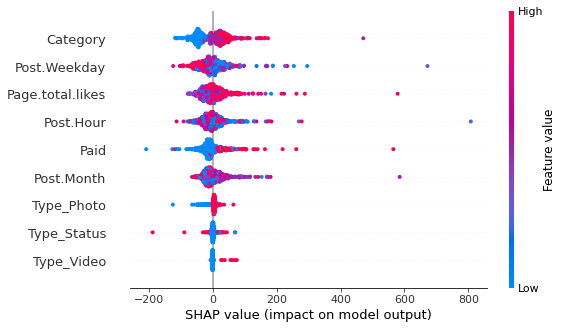

The rank correlation between ti and shap:
                         0
Category          0.926630
Post.Hour         0.900926
Post.Weekday      0.885177
Post.Month        0.883129
Page.total.likes  0.824727
Paid              0.808620
Type_Video        0.777542
Type_Photo        0.718909
Type_Status       0.688782

The tree interpreter score:
Page.total.likes 1.0839
Post.Hour 0.8814
Paid -0.6796
Post.Month 0.4363
Category -0.3961
Post.Weekday 0.2508
Type_Photo 0.1928
Type_Status 0.159
Type_Video -0.0101

The shapley value:
Post.Month 3.3429
Category -3.3275
Paid -2.9324
Page.total.likes 2.8056
Post.Hour 1.8914
Type_Photo 0.5353
Type_Video -0.3586
Post.Weekday -0.2375
Type_Status 0.1992


In [142]:
beeswarm_sr('fb',shap_all,ti_rs,shap_values) # dummies cause problems

Dummies from `Type`: 

  |Link | Photo | Status | Video 
  
  |  22  |  425  |   45   |   7 
    
Discovery: The importance of dummies judged by ti and shap is not consistent.

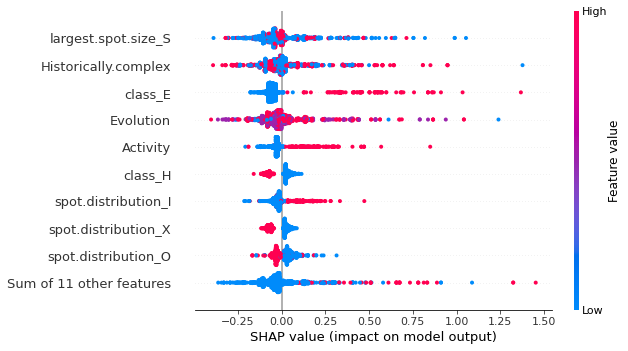

The rank correlation between ti and shap:
                                               0
largest.spot.size_R                     0.929331
largest.spot.size_K                     0.911320
Evolution                               0.899676
spot.distribution_O                     0.864120
largest.spot.size_H                     0.845756
largest.spot.size_X                     0.818978
class_C                                 0.798684
largest.spot.size_S                     0.795585
spot.distribution_I                     0.784656
Activity                                0.719675
Historically.complex                    0.717248
class_D                                 0.706135
class_H                                 0.702641
spot.distribution_X                     0.648643
Did.region.become.historically.complex  0.626487
Previous.24.hour.flare.activity.code    0.577792
class_F                                 0.481896
class_E                                 0.463257
Area                       

invalid value encountered in true_divide


In [143]:
beeswarm_sr('solar',shap_all,ti_rs,shap_values) # ti and shap are extremely low

In [152]:
(data['solar']["Area.of.the.largest.spot"]).unique() # Don't have variation

array([1], dtype=int32)

Discovery: There are too many dummies but ti and shap perform alilke at some dummies, though the importance scores are all low.

## Try to store the dictionary(result) into a .pickle file

In [252]:
# Try to store the data into a .pickle file

with open(save_path+'rmse_shap_ti.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [253]:
with open(save_path+'rmse_shap_ti.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    result_r = pickle.load(f)

In [254]:
result_r

{'df_abalone': array([[2.29249689, 2.24332425, 1.88867089],
        [2.17965879, 3.93917726, 3.38845327],
        [2.94756728, 0.96545717, 1.13926534],
        ...,
        [2.29092993, 1.9305574 , 1.50830876],
        [2.24298935, 1.66733383, 1.37688384],
        [2.19471186, 3.08331235, 2.98640348]]),
 'df_bike': array([[1634.37502782,  547.15852703,  548.41083819],
        [ 956.49602596, 2045.8931409 , 2215.49433419],
        [1441.09722871, 1464.04604443, 1635.66947999],
        ...,
        [1085.57002269, 2856.12298521, 3042.60480455],
        [1469.12099468, 1053.77170623, 1231.04010458],
        [ 643.61390038, 2781.21615851, 3050.25767473]]),
 'df_boston': array([[ 4.66253553,  8.23849387,  9.43898111],
        [ 5.53794091, 12.15708792, 13.03651689],
        [ 5.28038269,  8.6446925 ,  9.94960372],
        ...,
        [ 6.92232686,  1.14781149,  1.53824068],
        [ 5.34355926,  8.21693256,  8.92007901],
        [ 8.90983908,  0.03353189,  0.03647951]]),
 'df_concrete': a

# Classification

Rank correlation of global SHAP/TI

Qi said that she calculated rank correlation once. Therefore, I read the codes from RankCorr.py. There are three:

- corr   = {} # local rank correlations between shap and ti
- corr_f = {} # local rank correlations, filtered(80% global shap value)
- corr_g = {} # global ranke correlations




In [3]:
with open('/Users/aubrey/Documents/SHK/Dropbox/SharedFile/Results/rank_corr_global.pickle', 'rb') as f:
    rank_corr_global= pickle.load(f)

In [249]:
rank_corr_global['flags']

[0.9025974025974025, 0.9796134098459679, 0.9140742977952281]

In [4]:
rank_corr_global

{'segmentation': [0.9543859649122807, 0.9964912280701754, 0.9596491228070174],
 'vote': [0.8705882352941177, 0.9382352941176471, 0.9088235294117648],
 'crx': [0.8392857142857142, 0.9892857142857142, 0.8428571428571429],
 'Hill_Valley_without_noise': [0.8599099909990998,
  0.871071107110711,
  0.9726132613261325],
 'adult': [0.7230769230769231, 0.9472527472527472, 0.8549450549450549],
 'allbp': [0.7874369582604058, 0.9975339087546239, 0.7946764776786415],
 'allhyper': [0.8225273596311711, 0.9844660194174756, 0.833582127344614],
 'allhypo': [0.9498136645962733, 0.9915527950310558, 0.9562732919254656],
 'allrep': [0.9753521126760564, 0.9969818913480882, 0.9738430583501005],
 'analcatdata_aids': [1.0, 0.7999999999999999, 0.7999999999999999],
 'analcatdata_asbestos': [0.5, 1.0, 0.5],
 'analcatdata_authorship': [0.9010060362173038,
  0.987647624879713,
  0.8831248359723557],
 'analcatdata_bankruptcy': [0.8285714285714287, 1.0, 0.8285714285714287],
 'analcatdata_boxing1': [0.5, 1.0, 0.5],
 'a

In [7]:
len(rank_corr_global)

113

In [230]:
with open('/Users/aubrey/Documents/SHK/Dropbox/SharedFile/Results/rank_corr.pickle', 'rb') as f:
    rank_corr= pickle.load(f)

In [236]:
len(rank_corr)

113

In [243]:
rank_corr['flags']

0     0.973196
1     0.940319
2     0.909651
3     0.658153
4     0.950976
5     0.948385
6     0.783779
7     0.879736
8     0.925906
9     0.942955
10    0.947125
11    0.929677
12    0.851840
13    0.726394
14    0.948700
15    0.733002
16    0.901078
17    0.895542
18    0.904319
19    0.803811
20    0.835079
21    0.837863
22    0.803960
23    0.865874
24    0.883456
25    0.764201
26    0.802722
27    0.773400
28    0.882453
29    0.813538
30    0.923690
31    0.753533
32    0.906245
33    0.702896
34    0.936762
35    0.868756
36    0.938102
37    0.698900
38    0.809109
39    0.695731
40    0.880212
41    0.951727
42    0.857531
dtype: float64

In [251]:
rank_corr['flags'].mean()

0.8544251644849966

In [5]:
from scipy.stats import pearsonr 
# open GlobalImport.pickle that Qi stored
with open('/Users/aubrey/Documents/SHK/Dropbox/SharedFile/Results/GlobalImport.pickle', 'rb') as f:
    result_c= pickle.load(f)


In [6]:
result_c

{'flags': [[0.42013888888888895, 1.662734939923717, 1.908767, 1.8673685],
  [0.3797498797498797, 1.53422037884593, 0.30818373, 0.29418612],
  [0.2690909090909091, 1.5609133806493547, 0.0, 0.0],
  [0.3323700716845879, 1.7560059572570026, 1.1624364, 1.1630228],
  [0.3635566188197767, 1.8990857750177383, 2.7419813, 2.6873863],
  [0.4862433862433863, 1.5242381003788776, 1.7225333, 1.6865641],
  [0.46704434697855757, 1.4949089433066547, 2.2472608, 2.2583973],
  [0.4343415288519986, 1.5412040181302775, 2.0817657, 2.049242],
  [0.42096560846560854, 1.7298293132723, 1.9732294, 1.9577292],
  [0.3844854070660523, 1.8022738362972934, 2.3012168, 2.323433],
  [0.437363834422658, 1.3913362751870106, 1.0928395, 1.1508749],
  [0.42343885128265435, 1.7034695317140884, 2.3012168, 2.323433],
  [0.4951541514041515, 1.6039895770760875, 2.1604488, 2.2132163],
  [0.4710524361259656, 1.8658563084382978, 2.8262472, 2.8492646],
  [0.37070105820105825, 1.6042469575380285, 0.57418513, 0.6360712],
  [0.47105243612

In [5]:
len(result_c)

30

In [242]:
len(result_c['flags'])

500

In [223]:
to_delete = []
# Remark: 2 dataset 'lymphography' and 'parity5' has error, so delete them first
for name in result_c:
    d = result_c[name]
    if result_c[name]==[]:
        print(d,name)
        to_delete.append(name)

for i in range(len(to_delete)):
    del result_c[to_delete[i]]


[] labor
[] lymphography


In [224]:
# NOTE: elementwise comparison failed; this will raise an error in the future. due to code: data[name]==[]
to_delete = []
for name in result_c:
    d = pd.DataFrame(result_c[name])
    if np.isnan(pearsonr(d[0],d[2])[0]):
        print(name)
        to_delete.append(name)
        
for i in range(len(to_delete)):
    del result_c[to_delete[i]]

parity5


An input array is constant; the correlation coefficent is not defined.


In [226]:
c1,c2,c3,c4,c5 = [],[],[],[],[]

for i,name in enumerate(result_c):
    d = pd.DataFrame(result_c[name])
    c1.append(pearsonr(d[0].astype(float),d[2].astype(float))[0]) # f1 & shap 
    c2.append(pearsonr(d[0],d[3])[0]) # f1 & tree interpreter
    c3.append(pearsonr(d[1],d[2])[0]) # lloss & shap
    c4.append(pearsonr(d[1],d[3])[0]) # lloss & tree interpreter
    c5.append(spearmanr(abs(d[2]),abs(d[3]))[0]) # shap & ti

In [227]:
corr_shap_ti_s_classification = pd.DataFrame(c5)
corr_shap_ti_s_classification

,0
0,0.998534
1,0.999112
2,0.998425
3,0.991997
4,0.996907
5,0.874529
6,0.999962
7,0.999511
8,0.999983
9,0.999820


In [133]:

corr_shap_ti_s_classification.to_csv(save_path+"corr_shap_ti_s_classification.csv")

- shap.plots.beeswarm(shap_values) for fb and solar
- check Qi's .pickle file (number of dataset)
- mse -> rmse
- remove the grey band (CI) (smooth.line.args = list(se = FALSE, size = 0.25, color = "blue"))
- 

06/01/2021:

- Problem: the csv for plotting is also complete (?)


- cough, fever 800 dataset (even)
- 100 trees in random forest (ntry = 1)
- ti and shap for each feature